### Data Sourcing
Obtain the data from 1 July 2012 to 30 June 2022 for the following:
2012-07-01 to 2022-06-30
1. SPY (SPDR S & P 500 ETF)
2. XLE (Energy Sector SPDR)
3. VNQ (Real Estate)
4. XLF (Finance Sector SPDR)

In [1]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

import matplotlib.pyplot as plt
import numpy as np
import plotly as plotly
from scipy.stats import lognorm,shapiro,normaltest,norm
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
yahoo_financials = YahooFinancials('SPY')
data = yahoo_financials.get_historical_price_data(start_date='2012-07-01', 
                                                  end_date='2022-06-30', 
                                                  time_interval='weekly')
spy_df = pd.DataFrame(data['SPY']['prices'])
spy_df = spy_df.drop('date', axis=1).set_index('formatted_date')
spy_df.head(5)

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-07-02,137.800003,134.850006,136.479996,135.490005,487344100,111.143578
2012-07-09,136.229996,132.600006,135.380005,135.750000,686624500,111.356903
2012-07-16,138.179993,134.550003,135.440002,136.470001,622487000,111.947479
2012-07-23,139.070007,133.029999,134.470001,138.679993,840929800,113.760376
2012-07-30,139.639999,135.580002,138.520004,139.350006,723033300,114.310005


In [3]:
yahoo_financials = YahooFinancials('XLE')
data = yahoo_financials.get_historical_price_data(start_date='2012-07-01', 
                                                  end_date='2022-06-30', 
                                                  time_interval='weekly')
xle_df = pd.DataFrame(data['XLE']['prices'])
xle_df = xle_df.drop('date', axis=1).set_index('formatted_date')
xle_df.head(5)

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-07-02,68.699997,65.669998,66.370003,66.290001,53579500,45.183437
2012-07-09,66.830002,64.639999,66.239998,66.769997,78907900,45.510620
2012-07-16,68.839996,66.169998,66.559998,68.790001,72491200,46.887451
2012-07-23,70.489998,66.160004,67.360001,70.220001,64279700,47.862144
2012-07-30,70.870003,68.160004,70.120003,70.440002,67710800,48.012093


In [4]:
yahoo_financials = YahooFinancials('XLF')
data = yahoo_financials.get_historical_price_data(start_date='2012-07-01', 
                                                  end_date='2022-06-30', 
                                                  time_interval='weekly')
xlf_df = pd.DataFrame(data['XLF']['prices'])
xlf_df = xlf_df.drop('date', axis=1).set_index('formatted_date')
xlf_df.head(5)

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-07-02,12.063363,11.689683,11.949634,11.754671,224529107,9.619194
2012-07-09,11.965881,11.575955,11.722177,11.949634,385864090,9.778737
2012-07-16,12.006499,11.665313,11.957758,11.681560,337671056,9.559365
2012-07-23,12.063363,11.445979,11.462226,11.990252,338438585,9.811978
2012-07-30,12.103981,11.649066,11.965881,12.038993,379298059,9.851861


In [5]:
yahoo_financials = YahooFinancials('VNQ')
data = yahoo_financials.get_historical_price_data(start_date='2012-07-01', 
                                                  end_date='2022-06-30', 
                                                  time_interval='weekly')
vnq_df = pd.DataFrame(data['VNQ']['prices'])
vnq_df = vnq_df.drop('date', axis=1).set_index('formatted_date')
vnq_df.head(5)

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-07-02,66.690002,65.330002,65.940002,66.290001,8502500,43.696098
2012-07-09,66.809998,65.080002,66.290001,66.730003,8707000,43.986137
2012-07-16,67.709999,65.750000,66.680000,66.050003,9327300,43.537895
2012-07-23,67.010002,64.930000,65.269997,66.529999,7469200,43.854294
2012-07-30,67.480003,65.919998,66.620003,67.129997,9187800,44.249786


In [6]:
# Combined format for all prices data
combined_prices_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])
combined_prices_df['SPY'] = spy_df['adjclose']
combined_prices_df['VNQ'] = vnq_df['adjclose']
combined_prices_df['XLE'] = xle_df['adjclose']
combined_prices_df['XLF'] = xlf_df['adjclose']
combined_prices_df.head(5)

,SPY,VNQ,XLE,XLF
formatted_date,,,,
2012-07-02,111.143578,43.696098,45.183437,9.619194
2012-07-09,111.356903,43.986137,45.510620,9.778737
2012-07-16,111.947479,43.537895,46.887451,9.559365
2012-07-23,113.760376,43.854294,47.862144,9.811978
2012-07-30,114.310005,44.249786,48.012093,9.851861


<AxesSubplot:xlabel='formatted_date'>

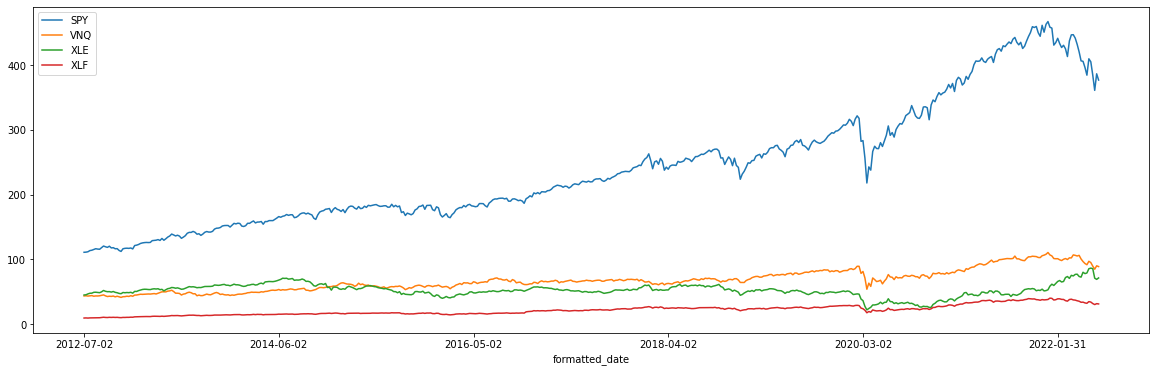

In [7]:
combined_prices_df.plot(kind='line', figsize=(20,6))

In [8]:
# Combined format of all return data (weekly return) (that is in percentage)
combined_rets_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])
combined_rets_df['SPY'] = spy_df['adjclose'].pct_change()
combined_rets_df['VNQ'] = vnq_df['adjclose'].pct_change()
combined_rets_df['XLE'] = xle_df['adjclose'].pct_change()
combined_rets_df['XLF'] = xlf_df['adjclose'].pct_change()
combined_rets_df.head(5)

,SPY,VNQ,XLE,XLF
formatted_date,,,,
2012-07-02,NaN,NaN,NaN,NaN
2012-07-09,0.001919,0.006638,0.007241,0.016586
2012-07-16,0.005303,-0.010191,0.030253,-0.022434
2012-07-23,0.016194,0.007267,0.020788,0.026426
2012-07-30,0.004831,0.009018,0.003133,0.004065


<AxesSubplot:xlabel='formatted_date'>

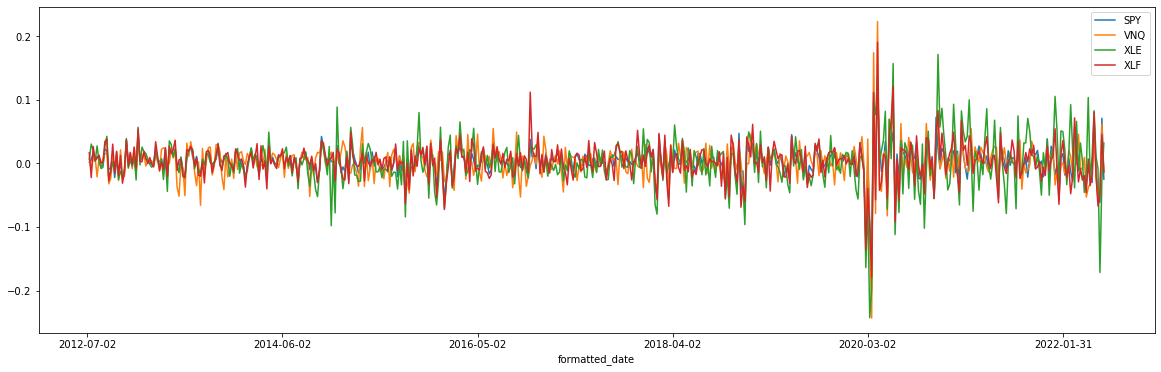

In [9]:
combined_rets_df.plot(kind='line', figsize=(20,6))

In [10]:
rec_count=20000
combined_log_rets_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])
combined_log_rets_df['SPY'] = np.log(spy_df['adjclose'])-np.log(spy_df['adjclose'].shift(1))
combined_log_rets_df['VNQ'] = np.log(vnq_df['adjclose'])-np.log(vnq_df['adjclose'].shift(1))
combined_log_rets_df['XLE'] = np.log(xle_df['adjclose'])-np.log(xle_df['adjclose'].shift(1))
combined_log_rets_df['XLF'] = np.log(xlf_df['adjclose'])-np.log(xlf_df['adjclose'].shift(1))
combined_log_rets_df.head(5)

,SPY,VNQ,XLE,XLF
formatted_date,,,,
2012-07-02,NaN,NaN,NaN,NaN
2012-07-09,0.001918,0.006616,0.007215,0.016450
2012-07-16,0.005289,-0.010243,0.029804,-0.022689
2012-07-23,0.016064,0.007241,0.020575,0.026083
2012-07-30,0.004820,0.008978,0.003128,0.004056


<AxesSubplot:xlabel='formatted_date'>

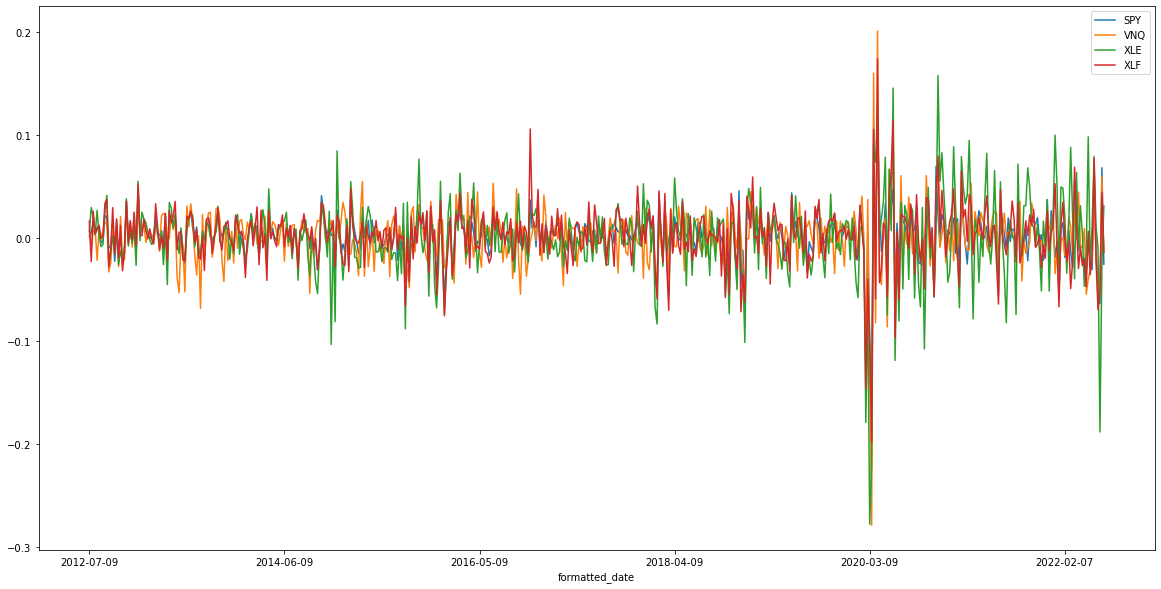

In [11]:
combined_log_rets_df.dropna(inplace = True),
combined_log_rets_df=combined_log_rets_df[-rec_count:]
combined_log_rets_df.plot(kind='line', figsize=(20,10))

### Test for normality

Text(0.5, 0, 'StdDev')

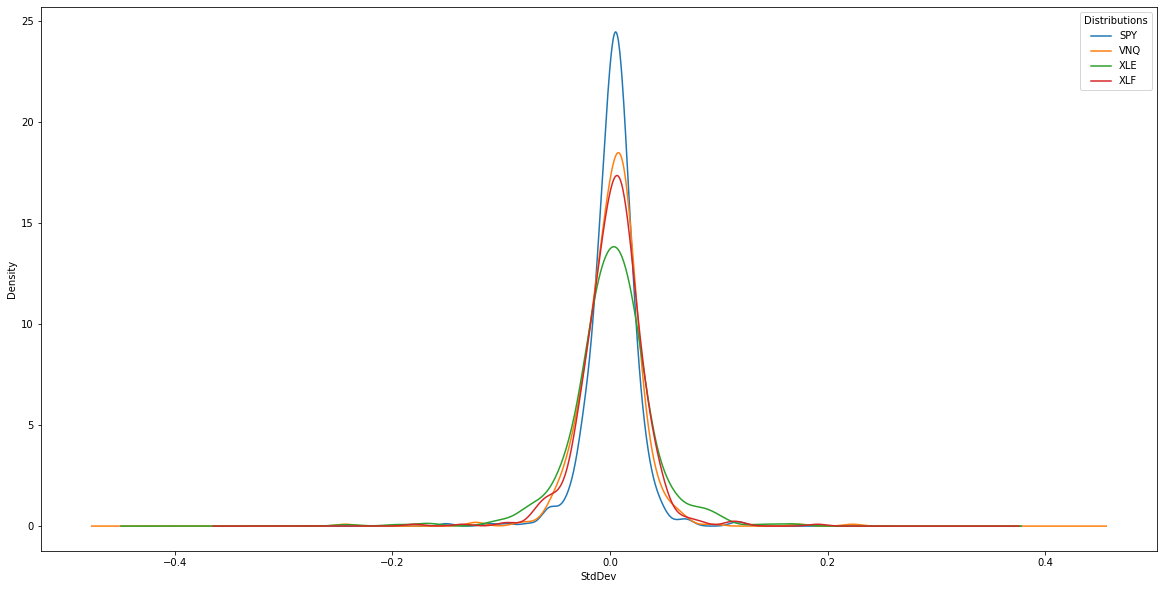

In [12]:
#plot distribution of points by team 
combined_rets_df.plot(kind='kde', figsize=(20,10))

#add legend
plt.legend(['SPY','VNQ','XLE','XLF'], title='Distributions')

#add x-axis label
plt.xlabel('StdDev')

In [13]:
# Combined Price Data Summaries:
combined_prices_df.describe()

,SPY,VNQ,XLE,XLF
count,522.000000,522.000000,522.000000,522.000000
mean,241.287462,67.571470,52.361450,21.801795
std,93.362881,16.325986,9.711112,7.551430
min,111.143578,41.485638,22.215620,9.559365
25%,171.625774,56.528527,48.544629,15.965699
50%,220.393295,66.157330,52.245113,21.212843
75%,283.811073,76.611357,57.637548,25.631480
max,467.377563,110.798218,86.670006,40.325771


In [14]:
# Combined Price Data (Central tendency and Dispersion) Summaries:

combined_prices_summary=pd.DataFrame({'Mean':combined_prices_df.mean(),
                        'Median':combined_prices_df.median(),
                         'SD':combined_prices_df.std(),
                         'Skewness':combined_prices_df.skew(),
                         'Kurtosis':combined_prices_df.kurtosis()}).round(6)
combined_prices_summary

,Mean,Median,SD,Skewness,Kurtosis
SPY,241.287462,220.393295,93.362881,0.793474,-0.315000
VNQ,67.571470,66.157330,16.325986,0.630079,-0.145596
XLE,52.361450,52.245113,9.711112,-0.110538,1.500427
XLF,21.801795,21.212843,7.551430,0.624808,-0.349983


In [15]:
# Combined rates data summaries 
combined_rets_df.describe()

,SPY,VNQ,XLE,XLF
count,521.000000,521.000000,521.000000,521.000000
mean,0.002595,0.001795,0.001624,0.002698
std,0.022172,0.029099,0.038104,0.029190
min,-0.150453,-0.243259,-0.242588,-0.179609
25%,-0.007757,-0.012201,-0.014809,-0.011515
50%,0.003970,0.003787,0.003133,0.004165
75%,0.013823,0.016124,0.020887,0.017481
max,0.120915,0.222842,0.171103,0.190428


In [16]:
# Combined Rates Data (Central tendency and Dispersion) Summaries:

combined_rates_summary=pd.DataFrame({'Mean':combined_rets_df.mean(),
                        'Median':combined_rets_df.median(),
                         'SD':combined_rets_df.std(),
                         'Skewness':combined_rets_df.skew(),
                         'Kurtosis':combined_rets_df.kurtosis()}).round(6)
combined_rates_summary

,Mean,Median,SD,Skewness,Kurtosis
SPY,0.002595,0.003970,0.022172,-0.693357,8.879396
VNQ,0.001795,0.003787,0.029099,-0.275380,18.496385
XLE,0.001624,0.003133,0.038104,-0.702861,6.991102
XLF,0.002698,0.004165,0.029190,-0.110342,7.769409


#### QQ Plot

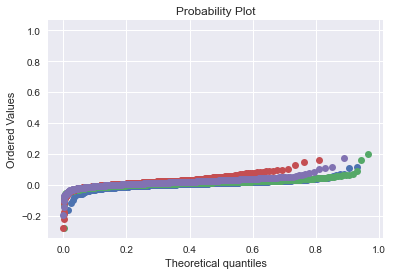

In [17]:
# Probability Plots

import scipy.stats as stats

plt.style.use('seaborn')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
stats.probplot(combined_log_rets_df['SPY'], dist=stats.beta, sparams=(2,3), plot=plt, fit=False)
stats.probplot(combined_log_rets_df['VNQ'], dist=stats.beta, sparams=(1,2), plot=plt, fit=False)
stats.probplot(combined_log_rets_df['XLE'], dist=stats.beta, sparams=(1,4), plot=plt, fit=False)
stats.probplot(combined_log_rets_df['XLF'], dist=stats.beta, sparams=(1,3), plot=plt, fit=False)

# Remove the regression lines
ax.get_lines()[1].remove()
ax.get_lines()[2].remove()
ax.get_lines()[3].remove()
ax.get_lines()[4].remove()

# Change colour of scatter
ax.get_lines()[0].set_markerfacecolor('C0')
ax.get_lines()[1].set_markerfacecolor('C1')
ax.get_lines()[2].set_markerfacecolor('C2')
ax.get_lines()[3].set_markerfacecolor('C3')

# Add on y=x line
ax.plot([0, 0], [1, 1], c='C4')

In [18]:
# Normal QQ Plot for Returns
'''
stock_symbol = 'SPY'
qq = sm.qqplot(combined_rets_df['SPY'],norm, fit=True, line="q")
qq.set_size_inches((7, 5))
plt.title(f"Normal QQ Plot for {stock_symbol} Return")
plt.show()
'''

'\nstock_symbol = \'SPY\'\nqq = sm.qqplot(combined_rets_df[\'SPY\'],norm, fit=True, line="q")\nqq.set_size_inches((7, 5))\nplt.title(f"Normal QQ Plot for {stock_symbol} Return")\nplt.show()\n'

#### Stationarity - ADF test

In [19]:
import statsmodels.tsa.stattools as st

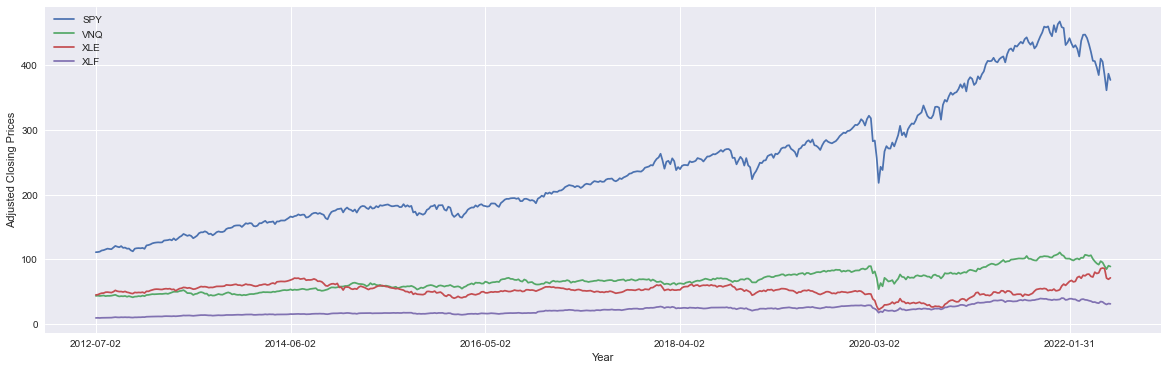

In [20]:
combined_prices_df.plot(kind='line', figsize=(20,6))
plt.ylabel("Adjusted Closing Prices")
plt.xlabel("Year")
plt.show()

In [21]:
combined_adf_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])
combined_adf_df['SPY'] = st.adfuller(x=spy_df['adjclose'], autolag="AIC") #regression="ct", maxlag=12)
combined_adf_df['VNQ'] = st.adfuller(x=vnq_df['adjclose'], autolag="AIC") #regression="ct", maxlag=12)
combined_adf_df['XLE'] = st.adfuller(x=xle_df['adjclose'], autolag="AIC") #regression="ct", maxlag=12)
combined_adf_df['XLF'] = st.adfuller(x=xlf_df['adjclose'], autolag="AIC") #regression="ct", maxlag=12)
print("spy adf:", combined_adf_df['SPY'][0], "adf_pvalue:", combined_adf_df['SPY'][1])
print("vnq adf:", combined_adf_df['VNQ'][0], "adf_pvalue:", combined_adf_df['VNQ'][1])
print("xle adf:", combined_adf_df['XLE'][0], "adf_pvalue:", combined_adf_df['XLE'][1])
print("xlf adf:", combined_adf_df['XLF'][0], "adf_pvalue:", combined_adf_df['XLF'][1])

spy adf: -0.6360366323614757 adf_pvalue: 0.8626295763634646
vnq adf: -1.2245898576702972 adf_pvalue: 0.6629293503461295
xle adf: -1.987259482871717 adf_pvalue: 0.2921871599631418
xlf adf: -1.2924955283662656 adf_pvalue: 0.6325985867198329


In [22]:
# Here p-value is far bigger than 0.005, so we can't reject null hypothesis, and can be concluded its not stationary.

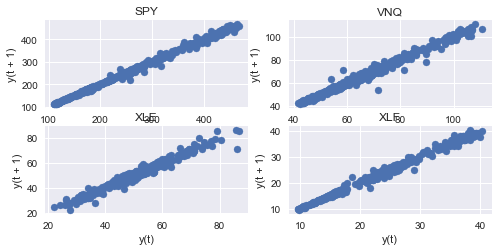

In [23]:
#import seaborn as sns
#c1 = sns.color_palette("YlOrRd_r", 4)
plt.subplot(321, title='SPY')
pd.plotting.lag_plot(combined_prices_df['SPY'], lag=1)

plt.subplot(322, title='VNQ')
pd.plotting.lag_plot(combined_prices_df['VNQ'], lag=1)

plt.subplot(323, title='XLE')
pd.plotting.lag_plot(combined_prices_df['XLE'], lag=1)

plt.subplot(324, title='XLF')
pd.plotting.lag_plot(combined_prices_df['XLF'], lag=1)

plt.show()

# Correlation is calculated between the variables itself at previous time steps, 
# such a correlation is called Autocorrelation.

In [24]:
# As we can see from the above tests and QQ plot the returns are not normally distributed. 
# Any analysis assuming the normal distribution of the data will not be applicable to these returns.

#### Regime shift tests

In [25]:
from statsmodels.tsa.stattools import adfuller
print("SPY: \n", adfuller(combined_rets_df['SPY'].dropna()))
print("VNQ: \n", adfuller(combined_rets_df['VNQ'].dropna()))
print("XLE: \n", adfuller(combined_rets_df['XLE'].dropna()))
print("XLF: \n", adfuller(combined_rets_df['XLF'].dropna()))

SPY: 
 (-24.963080509697384, 0.0, 0, 520, {'1%': -3.4429882202506255, '5%': -2.8671142122781066, '10%': -2.569738849852071}, -2385.4559413478323)
VNQ: 
 (-8.815778251180248, 1.936169671147854e-14, 7, 513, {'1%': -3.443161545965353, '5%': -2.8671904981615706, '10%': -2.5697795041589244}, -2130.760097799231)
XLE: 
 (-5.558944087196891, 1.5576566380391623e-06, 17, 503, {'1%': -3.4434175660489905, '5%': -2.8673031724657454, '10%': -2.5698395516760275}, -1858.340334708856)
XLF: 
 (-14.322828891243127, 1.1336375229344225e-26, 2, 518, {'1%': -3.443037261465839, '5%': -2.8671357972350493, '10%': -2.569750352856994}, -2112.244597435606)


#### Markov Switching Autoregressive Model

In [26]:
mod_kns = sm.tsa.MarkovRegression(combined_rets_df['SPY'].dropna(), k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    SPY   No. Observations:                  521
Model:               MarkovRegression   Log Likelihood                1346.217
Date:                Sun, 12 Mar 2023   AIC                          -2674.433
Time:                        18:39:08   BIC                          -2636.132
Sample:                    07-09-2012   HQIC                         -2659.430
                         - 06-27-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   1.89e-05      8.792      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0007      0.000      5.062      0.000       0.000       0.001
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0065      0.004      1.753      0.080      -0.001       0.014
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9716   7.47e-05    1.3e+04      0.000       0.971       0.972
p[1->0]        0.0551      0.023      2.426      0.015       0.011       0.100
p[2->0]    1.209e-106        nan        nan        nan         nan         nan
p[0->1]        0.0284    2.4e-05   1183.150      0.000       0.028       0.028
p[1->1]        0.9319      0.027     35.003      0.000       0.880       0.984
p[2->1]        0.1449      0.128      1.129      0.259      -0.107       0.396
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

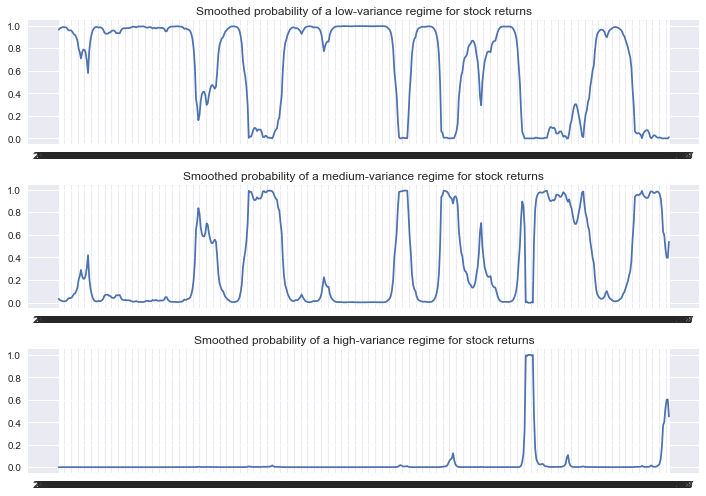

In [27]:
fig, axes = plt.subplots(3, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

In [28]:
mod_kns = sm.tsa.MarkovRegression(combined_rets_df['VNQ'].dropna(), k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    VNQ   No. Observations:                  521
Model:               MarkovRegression   Log Likelihood                1231.950
Date:                Sun, 12 Mar 2023   AIC                          -2445.899
Time:                        18:40:08   BIC                          -2407.597
Sample:                    07-09-2012   HQIC                         -2430.896
                         - 06-27-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   5.84e-05      5.282      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0007      0.000      5.236      0.000       0.000       0.001
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0115      0.004      2.810      0.005       0.003       0.020
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9697      0.022     43.656      0.000       0.926       1.013
p[1->0]        0.0486        nan        nan        nan         nan         nan
p[2->0]     4.295e-23        nan        nan        nan         nan         nan
p[0->1]        0.0271      0.021      1.277      0.202      -0.015       0.069
p[1->1]        0.9514        nan        nan        nan         nan         nan
p[2->1]        0.0596      0.057      1.051      0.293      -0.052       0.171
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

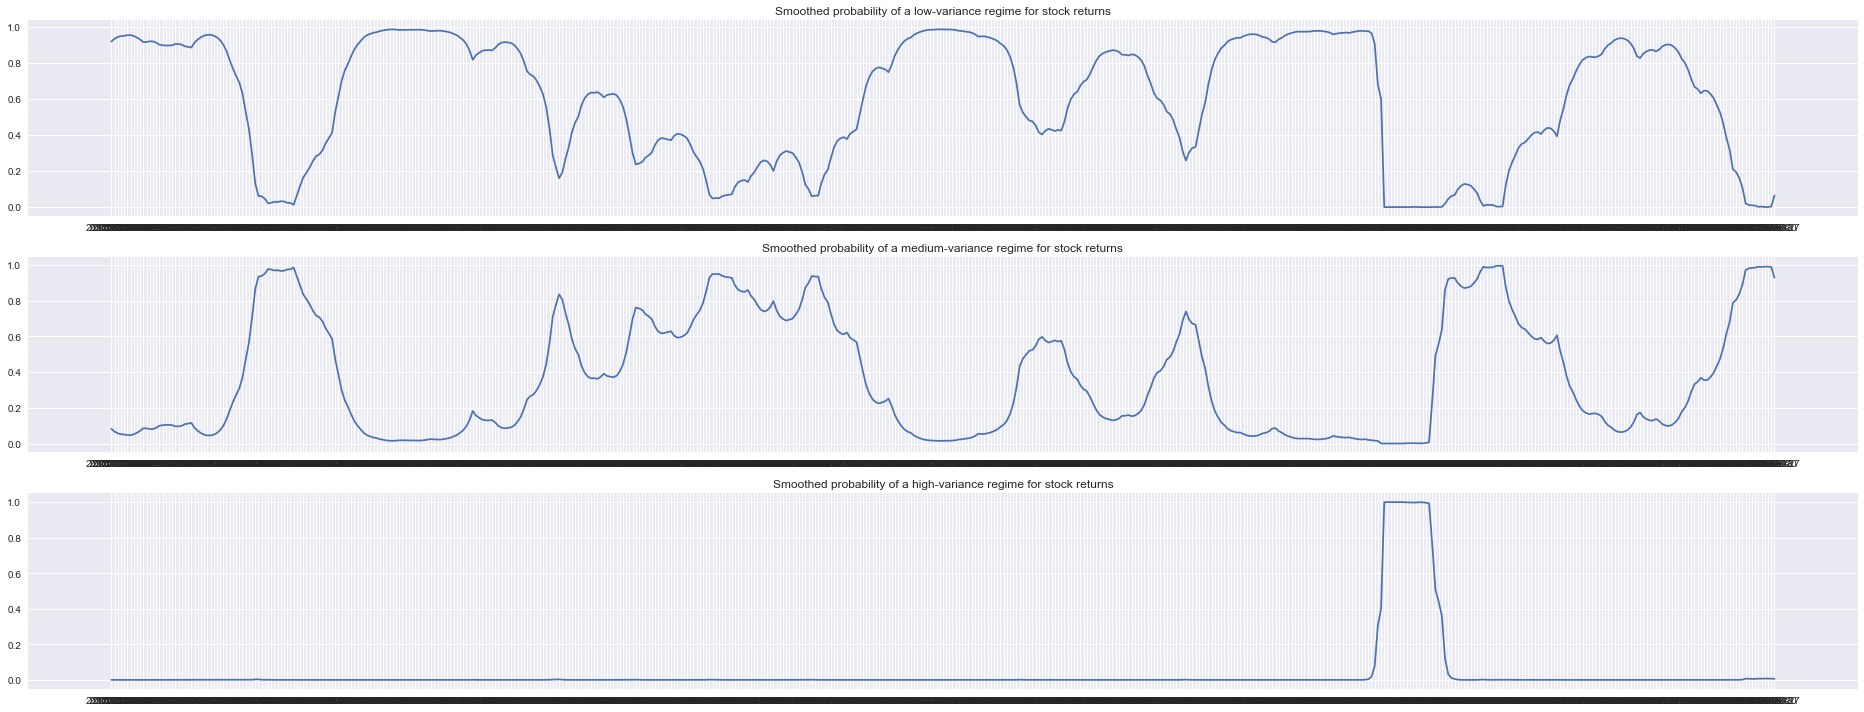

In [29]:
fig, axes = plt.subplots(3, figsize=(26,10))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


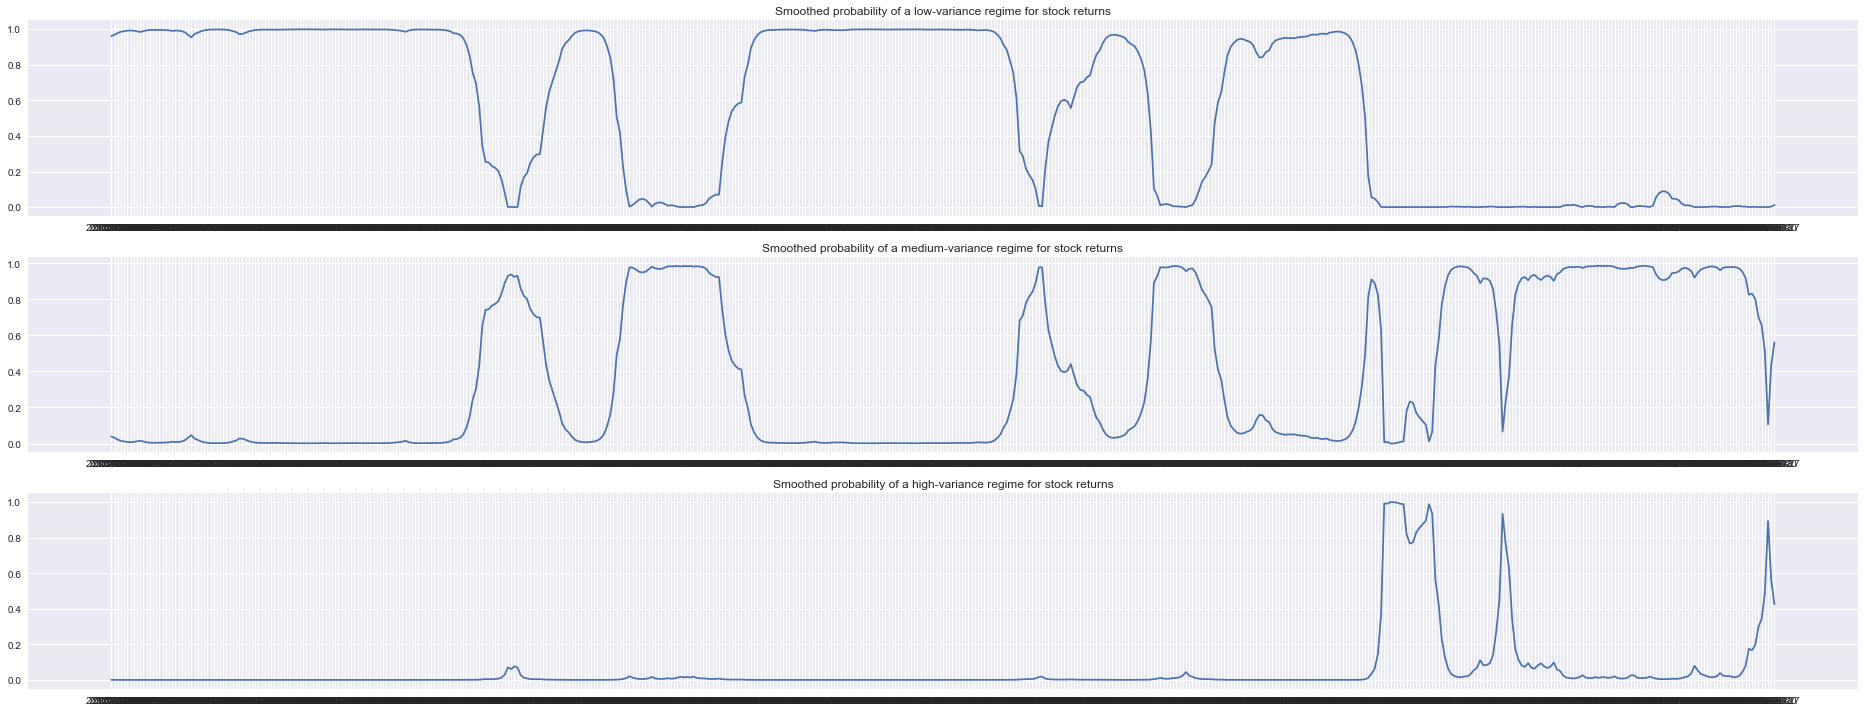

In [30]:
mod_kns = sm.tsa.MarkovRegression(combined_rets_df['XLE'].dropna(), k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

fig, axes = plt.subplots(3, figsize=(26,10))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


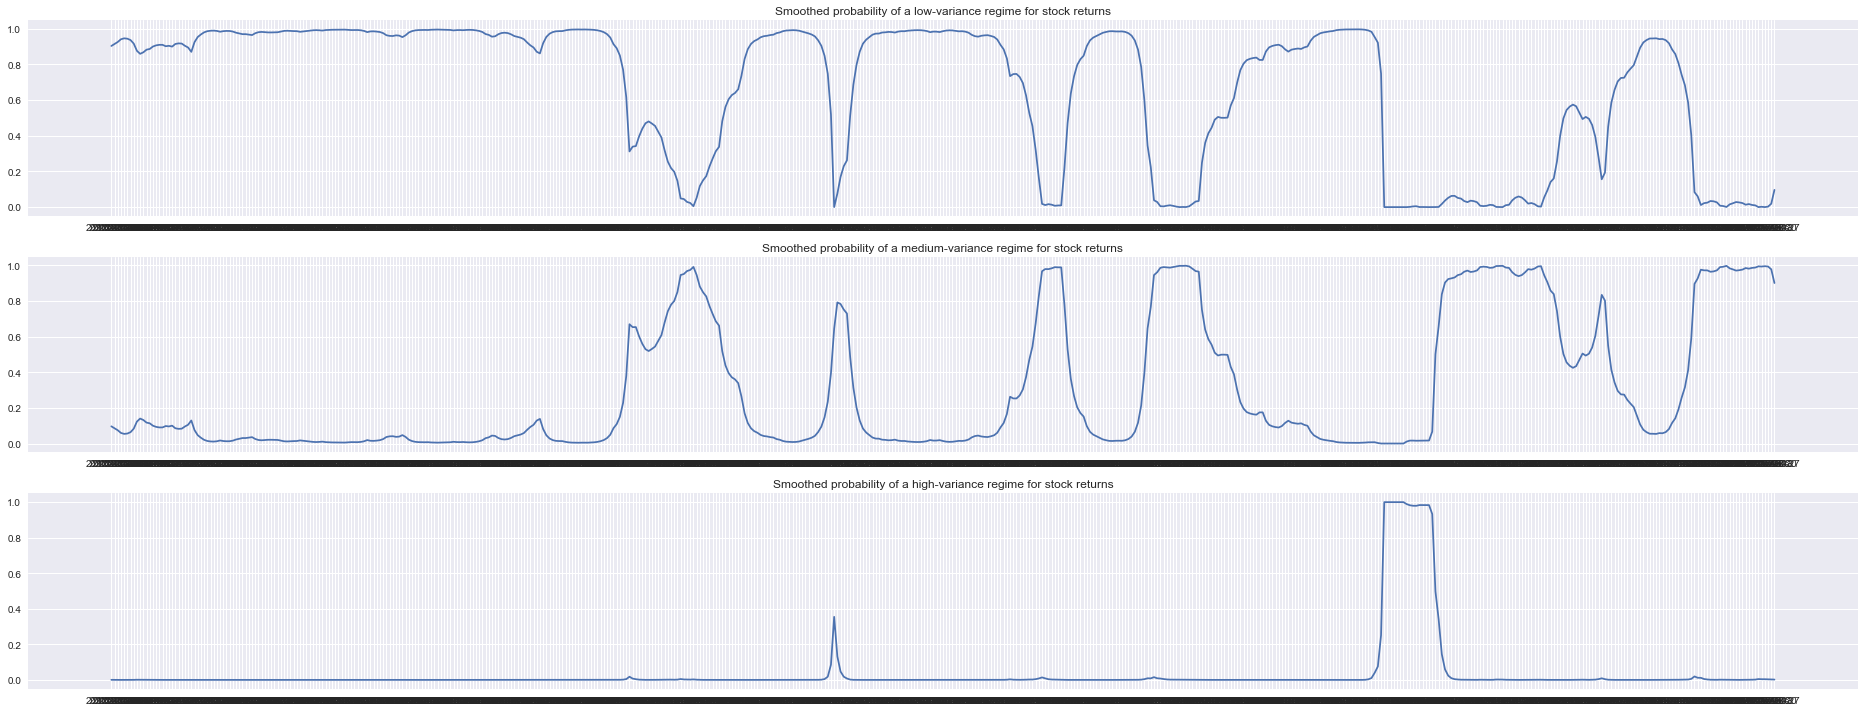

In [31]:
mod_kns = sm.tsa.MarkovRegression(combined_rets_df['XLF'].dropna(), k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

fig, axes = plt.subplots(3, figsize=(26,10))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

#### Correlation Matrix of prices

In [32]:
import seaborn as sb

In [33]:
corr = combined_prices_df.corr(method="pearson")
corr

,SPY,VNQ,XLE,XLF
SPY,1.000000,0.960008,-0.110996,0.972873
VNQ,0.960008,1.000000,-0.059088,0.956328
XLE,-0.110996,-0.059088,1.000000,0.006783
XLF,0.972873,0.956328,0.006783,1.000000


<AxesSubplot:>

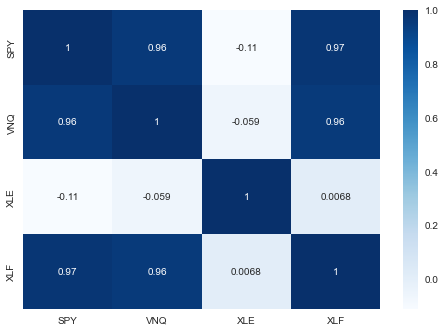

In [34]:
sb.heatmap(corr, cmap="Blues", annot=True)

In [35]:
corr = combined_prices_df.corr(method="kendall")
corr

,SPY,VNQ,XLE,XLF
SPY,1.000000,0.846390,-0.148935,0.876383
VNQ,0.846390,1.000000,-0.163903,0.798170
XLE,-0.148935,-0.163903,1.000000,-0.065889
XLF,0.876383,0.798170,-0.065889,1.000000


<AxesSubplot:>

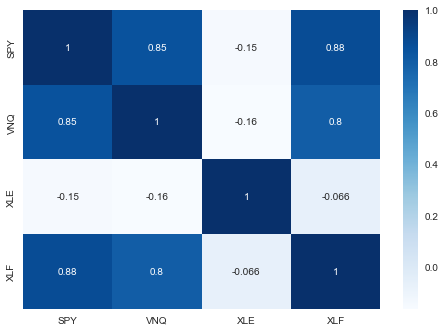

In [36]:
sb.heatmap(corr, cmap="Blues", annot=True)

In [37]:
corr = combined_prices_df.corr(method="spearman")
corr

,SPY,VNQ,XLE,XLF
SPY,1.000000,0.963934,-0.237281,0.968294
VNQ,0.963934,1.000000,-0.240102,0.934421
XLE,-0.237281,-0.240102,1.000000,-0.116319
XLF,0.968294,0.934421,-0.116319,1.000000


<AxesSubplot:>

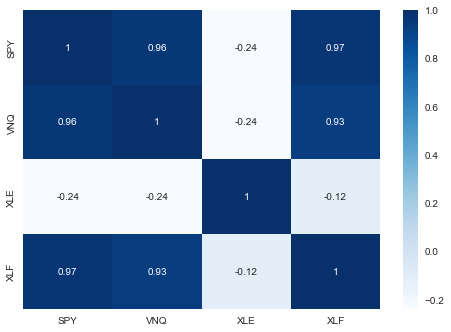

In [38]:
sb.heatmap(corr, cmap="Blues", annot=True)

### PCA analysis

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
# You must normalize the data before applying the fit method
df_normalized=(combined_prices_df - combined_prices_df.mean()) / combined_prices_df.std()
pca = PCA(n_components=combined_prices_df.shape[1])
pca.fit(df_normalized)

PCA(n_components=4)

In [40]:
# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=combined_prices_df.columns)
print(loadings)

          PC0       PC1       PC2       PC3
SPY  0.578953 -0.029211 -0.363768  0.729132
VNQ  0.574778  0.022896  0.816574 -0.048081
XLE -0.048848  0.995171  0.011447  0.084367
XLF  0.576244  0.090871 -0.448049 -0.677449


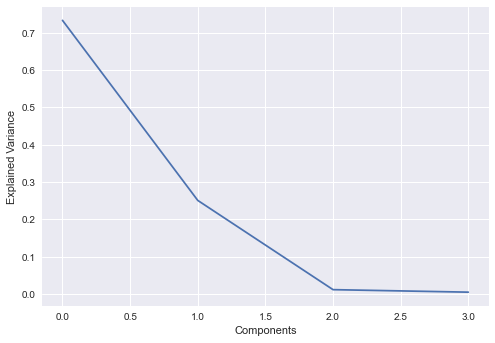

In [41]:
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

In [42]:
# PCA additional: which component tells what percentage is below. 
pca.explained_variance_ratio_*100

array([73.26922588, 25.06294818,  1.16939937,  0.49842658])

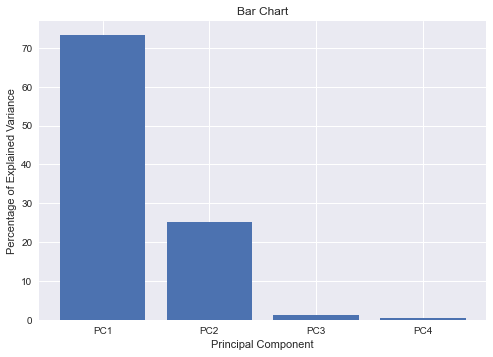

In [43]:
# In Chart
N = np.round(pca.explained_variance_ratio_*100,decimals=1)
plt.bar(range(0,len(pca.explained_variance_ratio_*100)), N, tick_label=['PC' + str(j) for j in range(1,len(N)+1)])
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Bar Chart')
plt.show()

In [44]:
# additional libraries
import scipy
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.tsa.stattools as ts

In [45]:
# k-means
kmeans = KMeans(3)
kmeans.fit(combined_prices_df.T)
labels = kmeans.predict(combined_prices_df.T)

In [46]:
df=pd.DataFrame({'labels':labels+1, 'companies':list(combined_prices_df.columns)}).sort_values(by=['labels'], axis = 0)
df

,labels,companies
1,1,VNQ
2,1,XLE
0,2,SPY
3,3,XLF


In [47]:
explained_variance_4_components = pca.explained_variance_ratio_

In [48]:
from scipy import stats
import seaborn as sns
import statistics as st

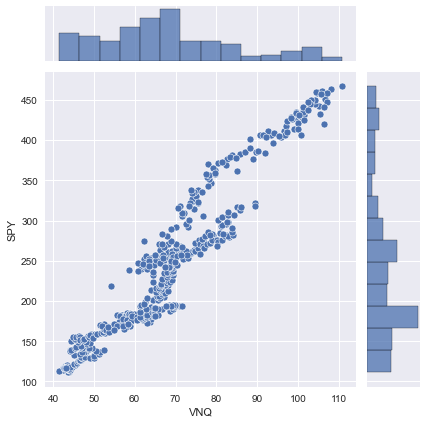

In [49]:
# Joint Distribution to study pair-wise ETFs
# SPY and VNQ
selected_series_VNQ = combined_prices_df[['SPY','VNQ']]
sns.jointplot(x=selected_series_VNQ['VNQ'], y=selected_series_VNQ['SPY'])

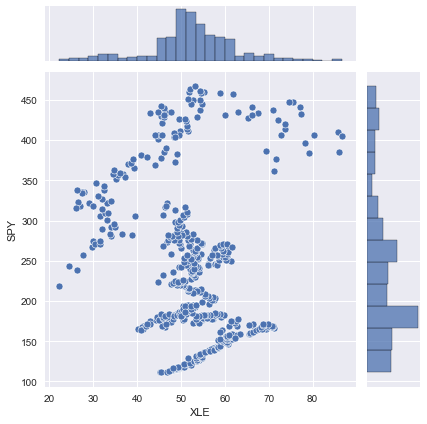

In [50]:
# Joint distribution of SPY with XLE
selected_series_XLE = combined_prices_df[['SPY','XLE']]
sns.jointplot(x=selected_series_XLE['XLE'], y=selected_series_XLE['SPY'])

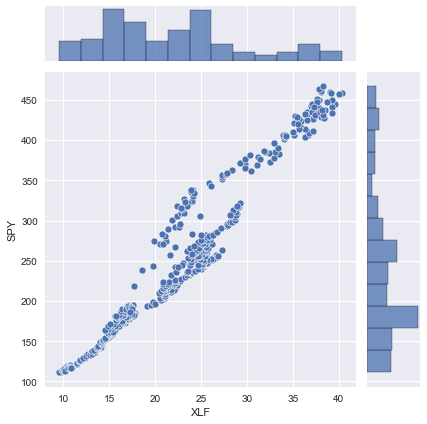

In [51]:
# Joint distribution of SPY with XLF
selected_series_XLF = combined_prices_df[['SPY','XLF']]
sns.jointplot(x=selected_series_XLF['XLF'], y=selected_series_XLF['SPY'])

In [52]:
covid_log_rets_df = combined_log_rets_df.loc['2019-06-01':'2020-12-31']
covid_log_rets_df.describe()

,SPY,VNQ,XLE,XLF
count,83.000000,83.000000,83.000000,83.000000
mean,0.004085,0.000563,-0.003817,0.002001
std,0.036672,0.055546,0.065306,0.048928
min,-0.163052,-0.278735,-0.277848,-0.197975
25%,-0.008571,-0.015609,-0.029722,-0.015099
50%,0.007751,0.003304,0.006603,0.006895
75%,0.017222,0.017147,0.026801,0.020890
max,0.114146,0.201178,0.157946,0.174313


### Covid regimeshift Identification

In [53]:
mod_kns = sm.tsa.MarkovRegression(covid_log_rets_df['SPY'].dropna(), k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    SPY   No. Observations:                   83
Model:               MarkovRegression   Log Likelihood                 187.342
Date:                Sun, 12 Mar 2023   AIC                           -356.685
Time:                        18:43:36   BIC                           -334.915
Sample:                    06-03-2019   HQIC                          -347.939
                         - 12-28-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   5.88e-05      3.512      0.000    9.13e-05       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0007      0.000      3.798      0.000       0.000       0.001
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0093      0.005      1.900      0.057      -0.000       0.019
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9683      0.032     30.363      0.000       0.906       1.031
p[1->0]        0.0322        nan        nan        nan         nan         nan
p[2->0]     3.962e-19        nan        nan        nan         nan         nan
p[0->1]     3.262e-19        nan        nan        nan         nan         nan
p[1->1]        0.9678        nan        nan        nan         nan         nan
p[2->1]        0.1424      0.122      1.163      0.245      -0.098       0.383
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

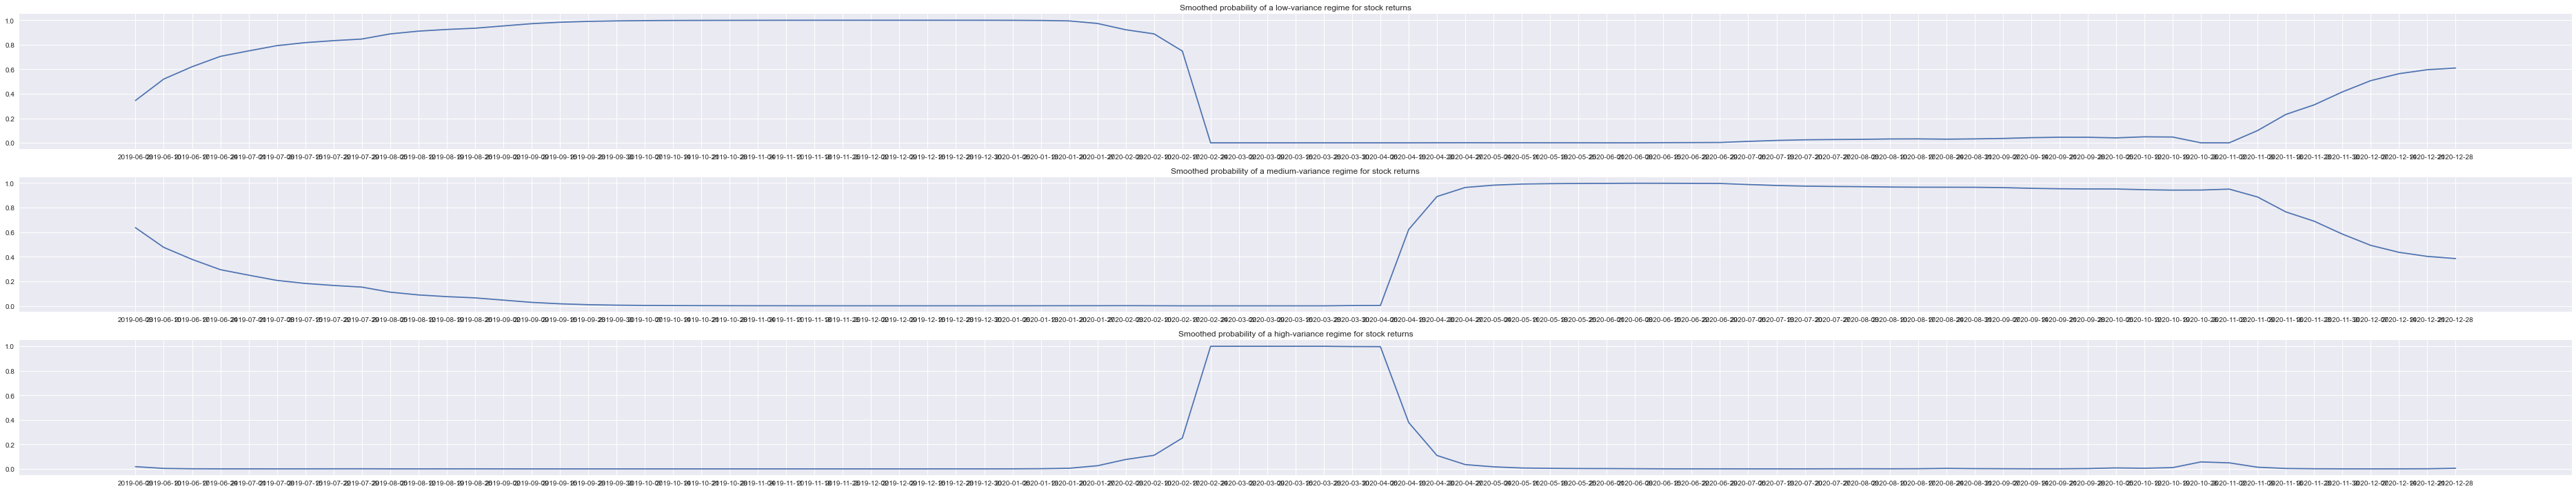

In [54]:
fig, axes = plt.subplots(3, figsize=(52,10))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

# study on which model fits best for SP 500

In [55]:
# Further Libraries added
from copulas.datasets import sample_trivariate_xyz
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_2d,compare_3d,scatter_2d,hist_1d,side_by_side
from copulas.multivariate import VineCopula

In [56]:
# Model Gaussian Copula
copula = GaussianMultivariate()
copula.fit(selected_series_VNQ['VNQ'])
# Transforming the columns to the best available distn by Copula
vnq_cdf = copula.univariates[0].cdf(selected_series_VNQ['VNQ'])

C:\Users\krish\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:5003: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
C:\Users\krish\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [57]:
'''
vnq_cdf = copula.univariates[0].cdf(selected_series_VNQ['VNQ'])
xle_cdf = copula.univariates[0].cdf(selected_series_XLE['XLE'])
xlf_cdf = copula.univariates[0].cdf(selected_series_XLF['XLF'])
'''

"\nvnq_cdf = copula.univariates[0].cdf(selected_series_VNQ['VNQ'])\nxle_cdf = copula.univariates[0].cdf(selected_series_XLE['XLE'])\nxlf_cdf = copula.univariates[0].cdf(selected_series_XLF['XLF'])\n"

# Copula journey unsuccessful

In [58]:
# Modeling before and after covid19

In [59]:
# During Covid (assume Covid 19 started near 1 July 2019 and ended around 31 March 2022)

yahoo_financials = YahooFinancials('SPY')
data = yahoo_financials.get_historical_price_data(start_date='2019-07-01', 
                                                  end_date='2022-03-31', 
                                                  time_interval='weekly')
spy_c_df = pd.DataFrame(data['SPY']['prices'])
spy_c_df = spy_c_df.drop('date', axis=1).set_index('formatted_date')
spy_c_df.head(3)

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2019-07-01,298.820007,294.329987,296.679993,298.459991,232786300,281.825104
2019-07-08,300.730011,295.480011,297.010010,300.649994,236543700,283.892944
2019-07-15,301.130005,296.700012,301.130005,297.170013,216657600,280.606964


In [60]:
# Covid study continued...

yahoo_financials = YahooFinancials('VNQ')
data = yahoo_financials.get_historical_price_data(start_date='2019-07-01', 
                                                  end_date='2022-03-31', 
                                                  time_interval='weekly')
vnq_c_df = pd.DataFrame(data['VNQ']['prices'])
vnq_c_df = vnq_c_df.drop('date', axis=1).set_index('formatted_date')
vnq_c_df.head(3)

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2019-07-01,90.010002,86.330002,87.980003,89.620003,28172800,79.086868
2019-07-08,91.000000,89.070000,89.529999,89.459999,23219400,78.945679
2019-07-15,89.980003,87.309998,89.580002,87.430000,25332100,77.154251


In [61]:
# Covid study continued...

yahoo_financials = YahooFinancials('XLE')
data = yahoo_financials.get_historical_price_data(start_date='2019-07-01', 
                                                  end_date='2022-03-31', 
                                                  time_interval='weekly')
xle_c_df = pd.DataFrame(data['XLE']['prices'])
xle_c_df = xle_c_df.drop('date', axis=1).set_index('formatted_date')
xle_c_df.head(3)

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2019-07-01,64.709999,62.459999,64.500000,63.090000,41332200,51.644295
2019-07-08,64.660004,62.660000,62.990002,64.440002,48646400,52.749378
2019-07-15,64.589996,61.799999,64.550003,62.759998,56510500,51.374165


In [62]:
# Covid study continued...

yahoo_financials = YahooFinancials('XLF')
data = yahoo_financials.get_historical_price_data(start_date='2019-07-01', 
                                                  end_date='2022-03-31', 
                                                  time_interval='weekly')
xlf_c_df = pd.DataFrame(data['XLF']['prices'])
xlf_c_df = xlf_c_df.drop('date', axis=1).set_index('formatted_date')
xlf_c_df.head(3)

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2019-07-01,28.27,27.709999,27.92,28.160000,169987800,26.151541
2019-07-08,28.32,27.809999,28.01,28.320000,160766600,26.300131
2019-07-15,28.35,27.780001,28.33,27.940001,186404700,25.947235


In [63]:
# Covid study continued...

combined_c_prices_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])
combined_c_prices_df['SPY'] = spy_c_df['adjclose']
combined_c_prices_df['VNQ'] = vnq_c_df['adjclose']
combined_c_prices_df['XLE'] = xle_c_df['adjclose']
combined_c_prices_df['XLF'] = xlf_c_df['adjclose']
combined_c_prices_df.head()

,SPY,VNQ,XLE,XLF
formatted_date,,,,
2019-07-01,281.825104,79.086868,51.644295,26.151541
2019-07-08,283.892944,78.945679,52.749378,26.300131
2019-07-15,280.606964,77.154251,51.374165,25.947235
2019-07-22,285.177246,77.913177,51.120403,26.643740
2019-07-29,276.310608,78.822113,49.442310,25.631479


In [64]:
combined_c_rets_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])
combined_c_rets_df['SPY'] = spy_c_df['adjclose'].pct_change()
combined_c_rets_df['VNQ'] = vnq_c_df['adjclose'].pct_change()
combined_c_rets_df['XLE'] = xle_c_df['adjclose'].pct_change()
combined_c_rets_df['XLF'] = xlf_c_df['adjclose'].pct_change()
combined_c_rets_df.head()

,SPY,VNQ,XLE,XLF
formatted_date,,,,
2019-07-01,NaN,NaN,NaN,NaN
2019-07-08,0.007337,-0.001785,0.021398,0.005682
2019-07-15,-0.011575,-0.022692,-0.026071,-0.013418
2019-07-22,0.016287,0.009836,-0.004939,0.026843
2019-07-29,-0.031092,0.011666,-0.032826,-0.037992


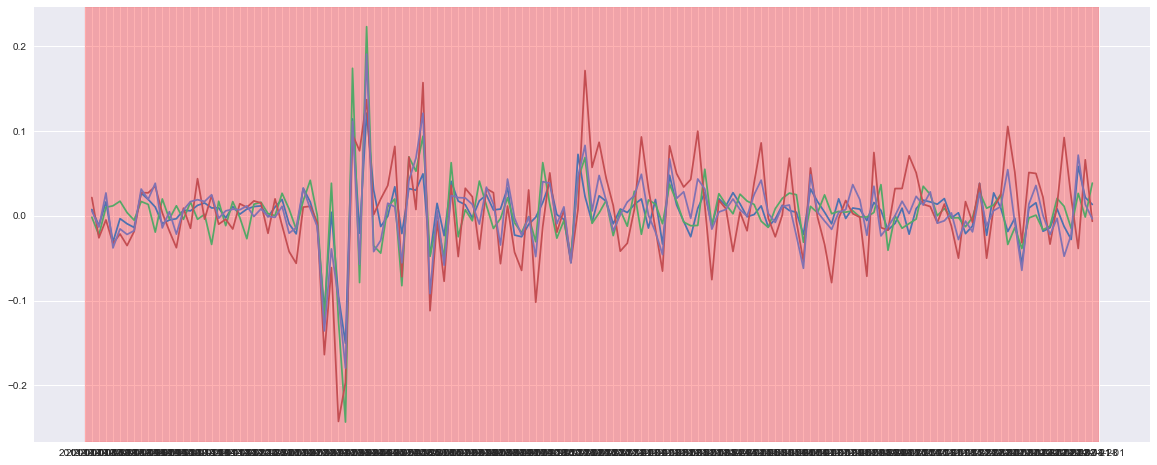

In [65]:
figure, axes = plt.subplots(figsize = (20,8))

axes.plot(combined_c_rets_df)
axes.axvspan('2019-07-01', '2022-01-01', color="red", alpha=0.3)
plt.show()

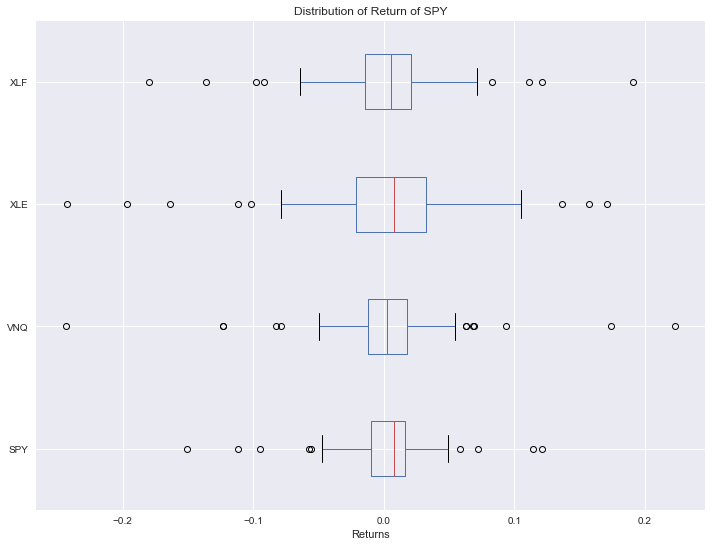

In [66]:
# Box plot
ax = combined_c_rets_df.boxplot(fontsize=10,vert=False, figsize=(12,9))
ax.set_xlabel("Returns")
ax.set_title("Distribution of Return of SPY")
plt.savefig('master_return.png', dpi=300, bbox_inches='tight')
plt.show()

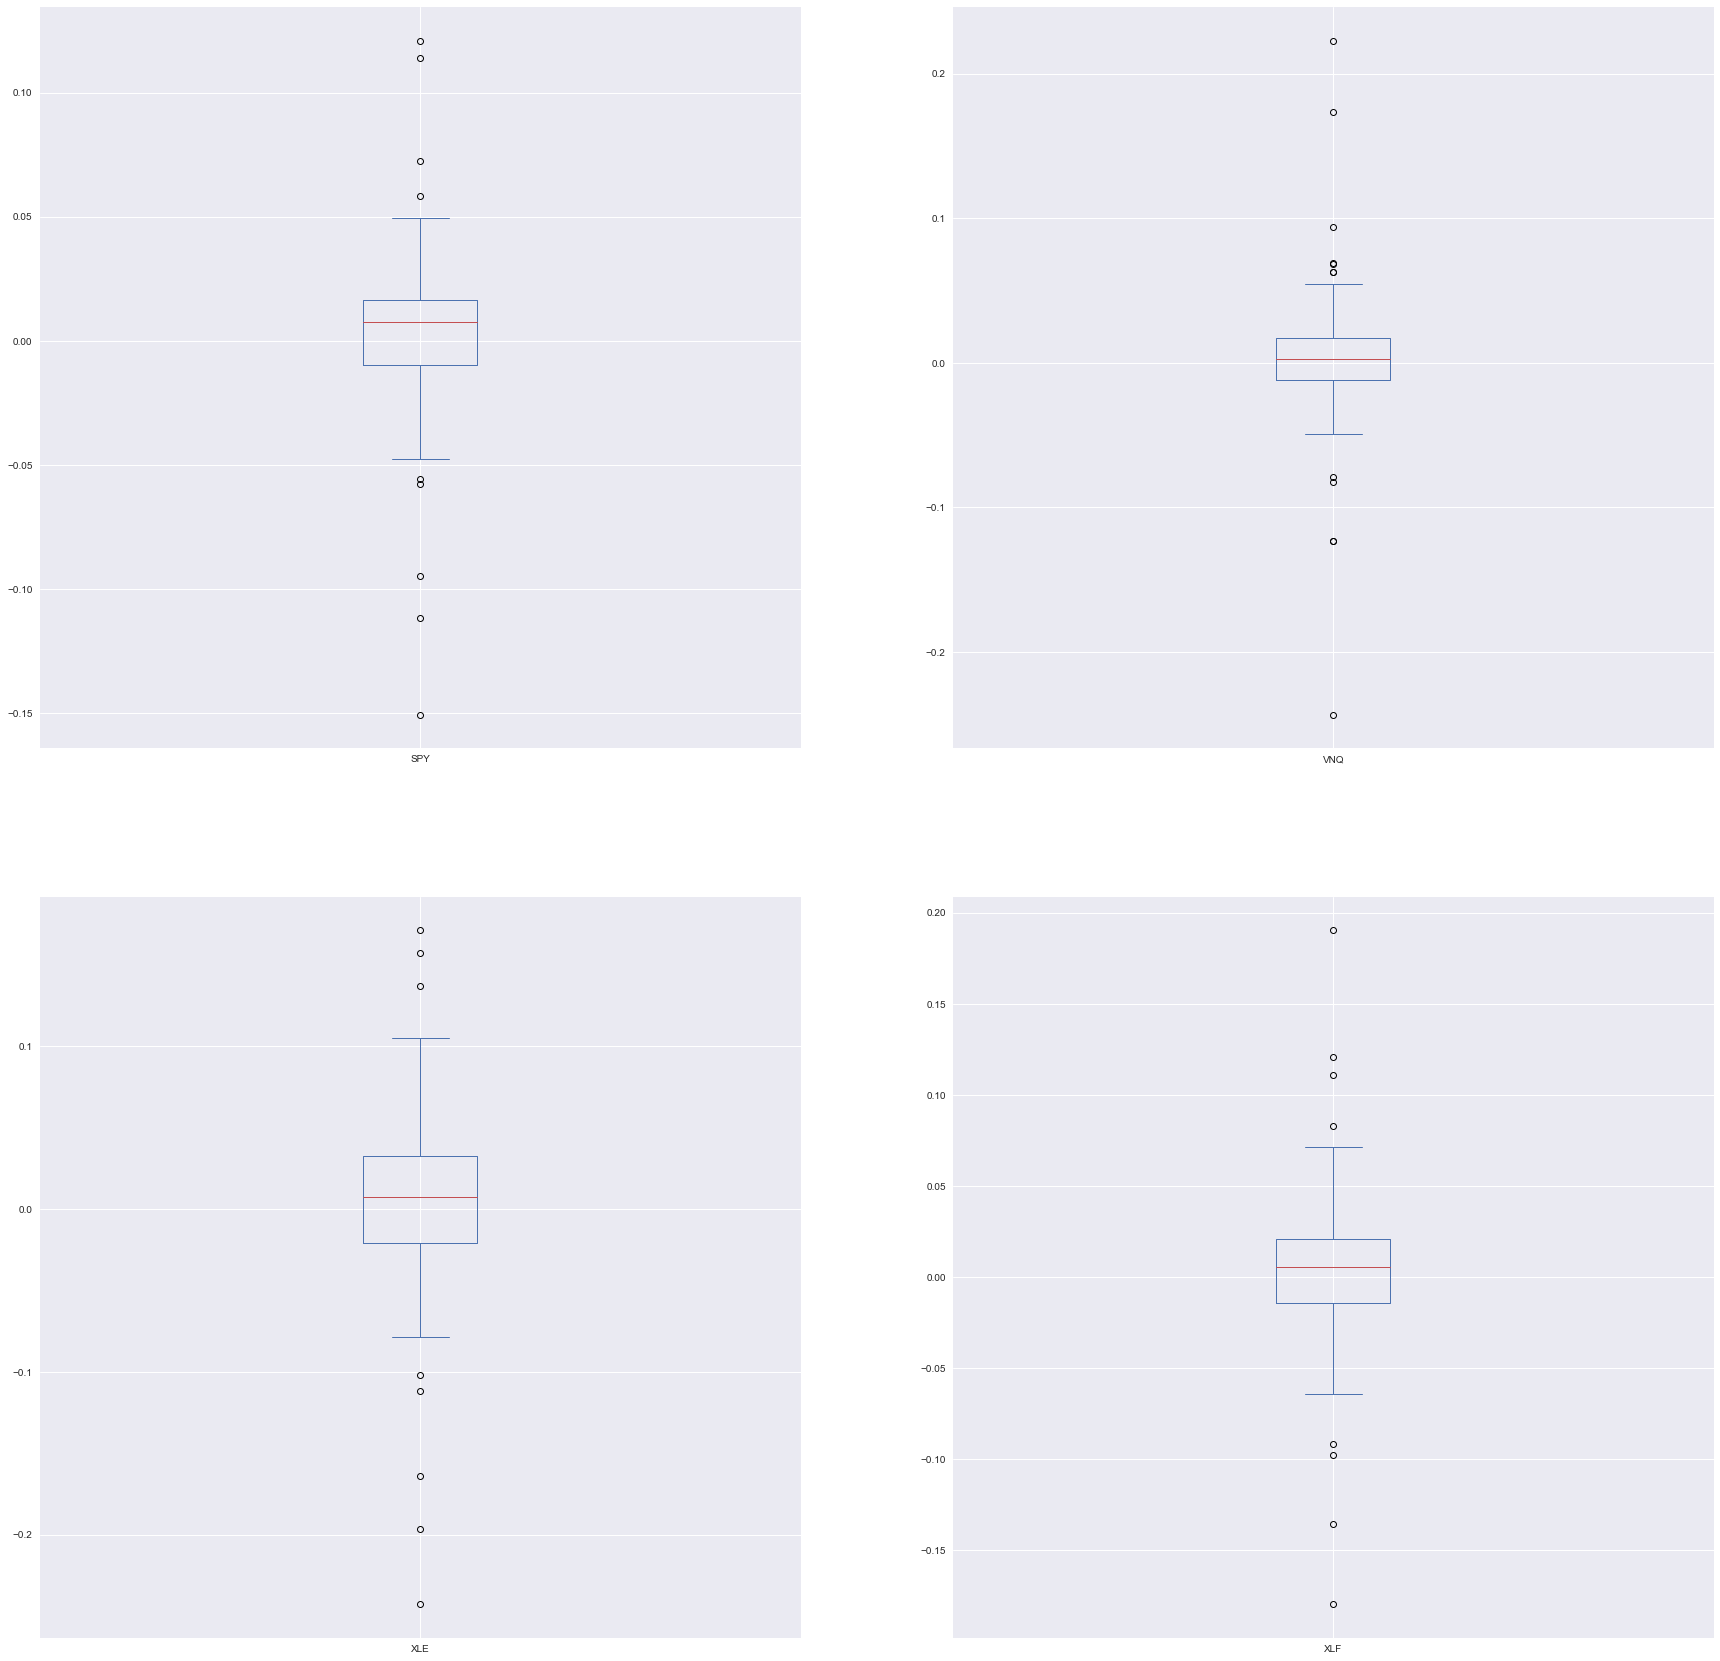

In [67]:
#Box plot
figure, axes = plt.subplots(2, 2)

axe = axes.ravel()

# assign the plot to each subplot in axe
for i, c in enumerate(combined_c_rets_df.columns):
    combined_c_rets_df[c].plot.box(ax=axe[i], figsize=(30, 30))

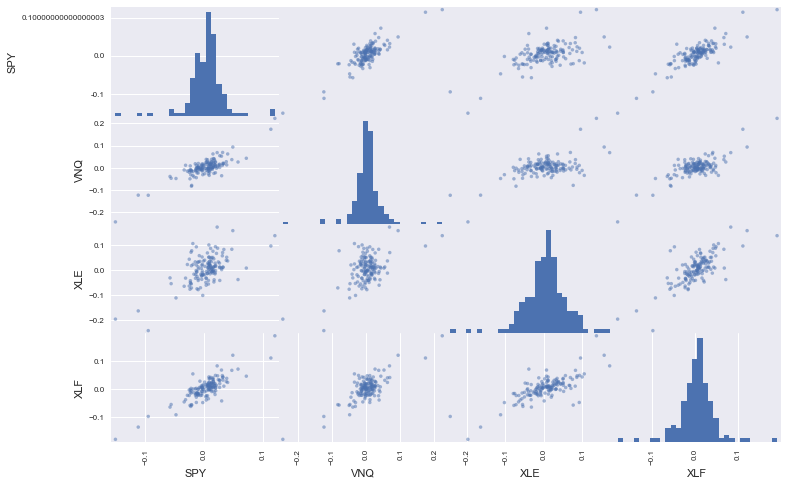

In [68]:
# Scatter plot Matrix on covid 19 time data
Scatter_Plot=pd.plotting.scatter_matrix(combined_c_rets_df,figsize=(12,8),hist_kwds={'bins':30})
plt.savefig('combined_c_rets_df.png', dpi=300, bbox_inches='tight')
plt.show()

In [69]:
# CADF
# Modeling before and after a specified range of time
#Get data before that specific date
spy_return= spy_df['adjclose'].pct_change().dropna()
spy_return.head(3)

formatted_date
2012-07-09    0.001919
2012-07-16    0.005303
2012-07-23    0.016194
Name: adjclose, dtype: float64

In [70]:
vnq_return= vnq_df['adjclose'].pct_change().dropna()
vnq_return.head(3)

formatted_date
2012-07-09    0.006638
2012-07-16   -0.010191
2012-07-23    0.007267
Name: adjclose, dtype: float64

In [71]:
# Modeling before and after a specified range of time
#Get data before that specific date
spy_before_covid19=spy_return[:"2019-07-01"]
vnq_before_covid19=vnq_return[:"2019-07-01"]

In [72]:
#CADF model function
def CADF(series1,series2):
    # Calculate optimal hedge ratio "beta"
    ols_model = sm.OLS(series1,series2)
    results = ols_model.fit()
    beta_hr = results.params[0]
    # Calculate the residuals of the linear combination
    residuals = series1 - beta_hr*series2
    ##Calculate and output the CADF test on the residuals
    cadf = ts.adfuller(residuals)
    print(cadf)

In [73]:
CADF(spy_before_covid19,vnq_before_covid19)

(-20.787078837303785, 0.0, 0, 364, {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}, -1943.415551191053)


In [74]:
# Modeling after a specified range of time
#Get data before that specific date
spy_after_covid19=spy_return["2022-03-31":]
vnq_after_covid19=vnq_return["2022-03-31":]

In [75]:
CADF(spy_after_covid19,vnq_after_covid19)

(-6.60004117182907, 6.7718128607800494e-09, 4, 8, {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625}, -91.59017688936535)


C:\Users\krish\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Text(0, 0.5, 'WCSS')

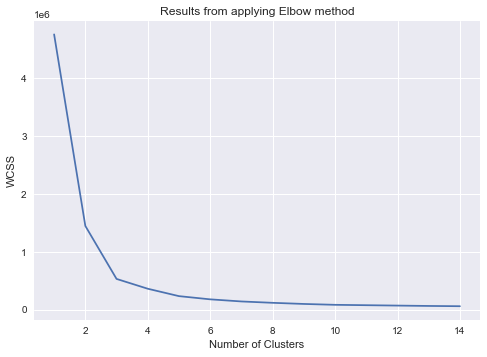

In [76]:
# Justification of value of k in k-menas  NEED TO SET IT TO THE APPROPRIATE PLACE WITH KMENAS ABOVE
w=[]
for i in range (1,15):
    k_m = KMeans(i)
    k_m.fit(combined_prices_df)
    iter = k_m.inertia_
    w.append(iter)
    
n_clusters = range(1,15)
plt.plot(n_clusters, w)
plt.title('Results from applying Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')


# INPUT GIVEN IN PRE and POST Covid 19

In [77]:
# Recalling data for covid 19 duration
combined_c_prices_df

,SPY,VNQ,XLE,XLF
formatted_date,,,,
2019-07-01,281.825104,79.086868,51.644295,26.151541
2019-07-08,283.892944,78.945679,52.749378,26.300131
2019-07-15,280.606964,77.154251,51.374165,25.947235
2019-07-22,285.177246,77.913177,51.120403,26.643740
2019-07-29,276.310608,78.822113,49.442310,25.631479
...,...,...,...,...
2022-02-28,425.270721,101.456253,72.152916,36.466568
2022-03-07,413.363892,99.942696,73.706650,35.653587
2022-03-14,437.423523,102.574554,70.858116,38.200272


In [78]:
# Recalling SPY data for the Covid 19 time
spy_c_df['adjclose']

formatted_date
2019-07-01    281.825104
2019-07-08    283.892944
2019-07-15    280.606964
2019-07-22    285.177246
2019-07-29    276.310608
                 ...    
2022-02-28    425.270721
2022-03-07    413.363892
2022-03-14    437.423523
2022-03-21    446.846985
2022-03-28    452.779449
Name: adjclose, Length: 144, dtype: float64

In [79]:
pre_covid19 = combined_c_prices_df[:"2019-09-01"]

In [80]:
post_covid19 = combined_c_prices_df["2021-03-31":]

In [81]:
y_pre = pre_covid19.pct_change().dropna()['SPY']
y_post = post_covid19.pct_change().dropna()['SPY']

In [82]:
X_pre = pre_covid19.pct_change().dropna()
X_post = post_covid19.pct_change().dropna()

In [83]:
X_pre = sm.add_constant(X_pre)
estimation = sm.OLS(y_pre, X_pre).fit()
estimation.summary()

C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\krish\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.625e+29
Date:                Sun, 12 Mar 2023   Prob (F-statistic):           7.44e-45
Time:                        18:44:17   Log-Likelihood:                 294.53
No. Observations:                   8   AIC:                            -579.1
Df Residuals:                       3   BIC:                            -578.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.301e-17   1.85e-17     -0.704      0.532   -7.18e-17    4.58e-17
SPY            1.0000   3.75e-15   2.67e+14      0.000       1.000       1.000
VNQ         1.388e-17   1.26e-15      0.011      0.992   -3.99e-15    4.02e-15
XLE        -5.551e-17   1.18e-15     -0.047      0.965    -3.8e-15    3.69e-15
XLF         5.551e-16   2.74e-15      0.202      0.853   -8.17e-15    9.28e-15
==============================================================================
Omnibus:                        0.365   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.833   Jarque-Bera (JB):                0.441
Skew:                          -0.291   Prob(JB):                        0.802
Kurtosis:                       2.008   Cond. No.                         320.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
X_post = sm.add_constant(X_post)
estimation = sm.OLS(y_post, X_post).fit()
estimation.summary()

C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.733e+30
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        18:44:17   Log-Likelihood:                 1854.8
No. Observations:                  51   AIC:                            -3700.
Df Residuals:                      46   BIC:                            -3690.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.534e-17   6.08e-18      5.812      0.000    2.31e-17    4.76e-17
SPY            1.0000   5.37e-16   1.86e+15      0.000       1.000       1.000
VNQ        -6.939e-17   4.23e-16     -0.164      0.870   -9.21e-16    7.82e-16
XLE         5.551e-17   1.62e-16      0.343      0.733   -2.71e-16    3.82e-16
XLF         1.735e-16   3.45e-16      0.503      0.617    -5.2e-16    8.67e-16
==============================================================================
Omnibus:                        6.572   Durbin-Watson:                   0.255
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                9.449
Skew:                           0.243   Prob(JB):                      0.00887
Kurtosis:                       5.052   Cond. No.                         115.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
# Mean-reverting Relationship
# Using CADF on prices
tmp = []
for x in range (0, len(combined_c_prices_df.columns)):
    t_stats = ts.adfuller(combined_c_prices_df.iloc[:,x], 1)[0]
    tmp.append([combined_c_prices_df.columns[x], t_stats])


In [86]:
tmp

[['SPY', -0.5725161976779881],
 ['VNQ', -0.7878153807934567],
 ['XLE', -0.17379180236693123],
 ['XLF', -0.6204691928264938]]

In [92]:
return_ts = combined_c_prices_df.pct_change().dropna()
return_ts

,SPY,VNQ,XLE,XLF
formatted_date,,,,
2019-07-08,0.007337,-0.001785,0.021398,0.005682
2019-07-15,-0.011575,-0.022692,-0.026071,-0.013418
2019-07-22,0.016287,0.009836,-0.004939,0.026843
2019-07-29,-0.031092,0.011666,-0.032826,-0.037992
2019-08-05,-0.003418,0.017130,-0.021523,-0.015580
...,...,...,...,...
2022-02-28,-0.012747,0.011048,0.092189,-0.047826
2022-03-07,-0.027998,-0.014918,0.021534,-0.022294
2022-03-14,0.058204,0.026334,-0.038647,0.071429


In [93]:
# Using CADF  to test mean-reverting relationship
tmp = []
for x in range (0, len(return_ts.columns)):
    t_stats = ts.adfuller(return_ts.iloc[:,x], 1)[0]
    tmp.append([return_ts.columns[x], t_stats])
tmp

[['SPY', -12.986613791626338],
 ['VNQ', -15.589371608217544],
 ['XLE', -10.008056363548784],
 ['XLF', -12.86851784441295]]

In [94]:
mean_reverting_df = pd.DataFrame(tmp, columns = ["ETFs","ADF T-tests"])

In [95]:
mean_reverting_df

,ETFs,ADF T-tests
0,SPY,-12.986614
1,VNQ,-15.589372
2,XLE,-10.008056
3,XLF,-12.868518


In [99]:
X_variables = combined_c_prices_df #[['SPY', 'VNQ', 'XLE', 'XLF']]
vif_data = pd.DataFrame()
vif_data['features'] = X_variables.columns
vif_data ['VIF'] = [variance_inflation_factor(X_variables.values, i)
    for i in range (len(X_variables.columns))]
vif_data

,features,VIF
0,SPY,406.495133
1,VNQ,266.318000
2,XLE,84.407593
3,XLF,480.293167


## APPENDIX
some extra code which may be useful for experiments are kept here, Not to use in thesis writing now.

In [97]:
from fredapi import Fred
# FRED API key
fred_key = "0e42125b8d25e5d7a6b4f26132eb7b1e";
# Initiates a session with the FRED datacenter to recieve datasets
fred = Fred(api_key=fred_key);
# Retrieve data from FRED API

fed_effective_rates_df = pd.DataFrame(fred.get_series('FEDFUNDS'));

In [98]:
fed_effective_rates_df.head()

,0
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83


After discussion with Kenneth Abott:
    
    1. Working with weekly data,
    2. Test for statistical distributions
    3. Do different tests including ADF
    4. Check first order serial autocorrelation
    5. Plotting graphs, correlation matrices,
    6. Check regime shift, 
    7. Basic statistical analysis from dispersion (skewness, kurtosis). 

#### Resampling

In [ ]:
#TBD

#### Gathering data from Fred for Indicators purpose

In [ ]:
#TBD

### Data Display
#### Plotting for Outliers

In [ ]:
# TBD
# Boxplot
# Correlation heat map

##### Cluster correlation analysis

In [ ]:
# TBD
# cluster correlation matrix
# Scatter plot
# Time series plot
# Density plot


#### Calculating Daily Returns

In [ ]:
# TBD

In [ ]:
# PCA Analsis
# Extreme value tracing
# Modelling Data
## QQ Plot normalization
# Jorgue -Berra Test
# QQ Plot normalization 

# Gaussian F-test
# Normalization test
# 

## Model - fitting
# Copula
# Gaussian Copula
# Normal distribution
# Non Gaussian Copula
# Model Vine Copula
# 

## Regime Tests
#  Get data 
# CADF model function
# mean reverting relationship
# 